# PUF Counties Aggregate - Factor Analysis

DeSYNPuf Counties Aggregate with Elixhauser Sums per User & RWJF Factor Rankings Dataset

In [1]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and RWJF County Health Factors and Outcomes Ranking Data from 2010.

2947 out of 3012 counties will be analyzed.

In [2]:
medicare_counties = pd.read_csv(r'D:\UC Davies healthcare analytics program\HCA203\final project data files\PUF_RWJF_MERGED.csv')
medicare_counties.shape


(2947, 69)

In [3]:
medicare_counties.drop(columns=medicare_counties.columns[0], axis=1, inplace=True, errors="ignore")

## Factor Analysis

The purpose of this notebook is to search for Latent Explanatory Variables within the data set.

After examining this angle here, I will try various dimension reduction methods other than PCA in another notebook.

In [8]:
from factor_analyzer import FactorAnalyzer

Prepare for Factor Analysis by subsetting to significant variables, and dropping NULLs.

In [9]:
analysis_ds = medicare_counties[["FIPS_COUNTY_CODE", "CNTY_MEAN_AGE","DIVERSE_PROP","CNTY_USR_PROP", "TOT_VSTS_PB", "CNTY_IP_PROP",
                                "CODES_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_CC_PREV", 
                                "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK"]]


analysis_ds = analysis_ds.dropna()
analysis_ds.shape


(2909, 15)

## Bartlett Test for Sphericity

A significant result (low p-value) indicates that a Factor Analysis may be appropriate.

In [10]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(analysis_ds)
chi_square_value, p_value

(22151.244592979747, 0.0)

## Kaiser-Meyer-Olkin (KMO) Test 

This test measures the suitability of the specific variables in the data set, and the model as a whole, for factor analysis. 

It estimates the *proportion of variance* among all the observed variables. 

A lower proportion is more suitable for factor analysis. 

The KMO test values range between 0 and 1. **Value less than 0.6 are considered inadequate**.

In [11]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7208039738179739

In [12]:
kmo_all

array([0.66206374, 0.50914309, 0.60546117, 0.52520036, 0.72791627,
       0.56042061, 0.68365476, 0.831551  , 0.93616668, 0.74092454,
       0.79979539, 0.81311367, 0.90003505, 0.49740298, 0.49999685])

These results indicate that some of the variables are inadequate.

Specifically, variable 2 (CNTY_USR_PROP), variable 13 (HO_PROP_RANK) and variable 14 (HF_PROP_RANK).  

The other variables are adequate (>.6).  

To remove variables based on the results of the KMO test, we should drop the **lowest value** variable first and re-run the test - removing only one variable at a time.

In [13]:
analysis_ds = analysis_ds.drop("HO_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7425915083148175

In [14]:
kmo_all

array([0.66363612, 0.51059372, 0.60763444, 0.52492035, 0.7278178 ,
       0.56360503, 0.68355325, 0.831319  , 0.93614767, 0.74095959,
       0.79974091, 0.81339519, 0.90271735, 0.60111604])

Now that we have removed HO_PROP_RANK, the value of HF_PROP_RANK has improved!

Looks like the only other value to remove is CNTY_USR_PROP.

In [15]:
analysis_ds = analysis_ds.drop("CNTY_MEAN_AGE", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.744203822427132

In [16]:
kmo_all

array([0.66211716, 0.67205377, 0.52525929, 0.72804192, 0.56363781,
       0.68429185, 0.83172678, 0.93642102, 0.74312827, 0.7998109 ,
       0.81348122, 0.90515754, 0.60261388])

The overall KMO for the model is looking very promising!

However, now we can see that the geographical indicator (FIPS_COUNTY_CODE) is no longer adequate...

In [17]:
analysis_ds = analysis_ds.drop("CNTY_USR_PROP", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model


0.7644882466091546

In [18]:
kmo_all

array([0.51736382, 0.6984979 , 0.80595207, 0.5810658 , 0.73741953,
       0.78180924, 0.92956331, 0.72970598, 0.70200088, 0.76069376,
       0.89221498, 0.64367271])

In [19]:
analysis_ds = analysis_ds.drop("FIPS_COUNTY_CODE", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7656819366388518

In [20]:
kmo_all

array([0.7899082 , 0.80544783, 0.58083626, 0.73715941, 0.78196987,
       0.93812317, 0.72972685, 0.70025487, 0.75996592, 0.89203346,
       0.66097842])

In [21]:
analysis_ds = analysis_ds.drop("CNTY_IP_PROP", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7581195689265747

In [22]:
kmo_all

array([0.77743574, 0.79868148, 0.71981753, 0.77532807, 0.93982075,
       0.62364179, 0.69536907, 0.75796371, 0.86589208, 0.67235064])

The final 12 variables look good, and the overall score is excellent!

Now, we can attempt the factor analysis.

Our most meritorious variable is... PRVDRS_PU.

### The final list of variables to be analyzed:

TOT_VSTS_PB   
Total Visits per Beneficiary

CNTY_IP_PROP  
The Proportion of Visits that are Inpatient

CODES_PU      
The Number of Codes per User (A User is a beneficiary with >0 claims for the period (2008-2010))

PROCS_PU      
The Number of Procedures per User (based on HCPCS Level 1 Codes)

PRVDRS_PU     
The Number of Providers per User

TOT_IPDAYS_PU 
The Total Number of Inpatient Days per User

TOT_CC_PREV   
The Total Number of Chronic Conditions / The Number of Beneficiaries in the County

TOT_CC_INCD   
The Total # of New Chronic Conditions during the period / The # of Beneficiaries in the County

TOT_ELIX_PU   
The Sum of all the Avg Elixhauser Scores for all the Users in the County / # of Users 

TOT_COST_PB   
The Total Cost / Number of Beneficiaries in the County

HF_PROP_RANK  
The RWJF Health Factors Proportionate Rank for the County

DIVERSE_PROP  
The Proportion of people in the county whose self-identified race is not white.


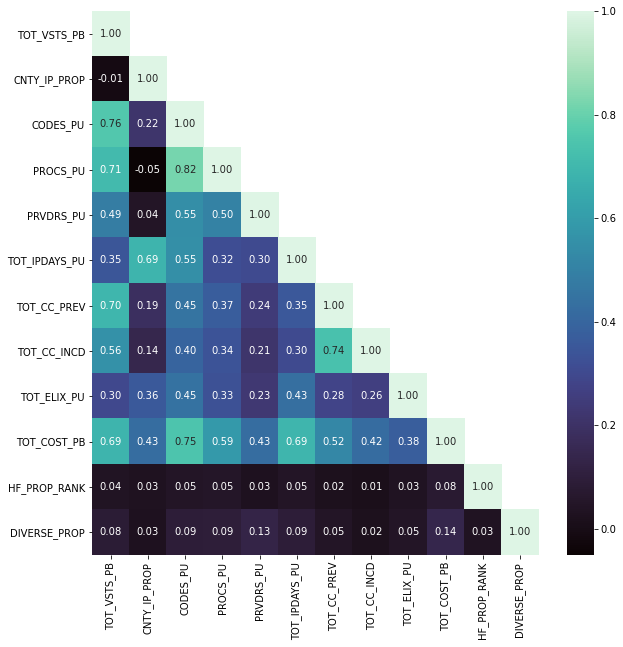

In [17]:
# Don't use pearson correlation on non-normal data

analysis_corr = analysis_ds.corr(method="spearman")
lower_corr = analysis_corr.where(np.tril(np.ones(analysis_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
analysis_hmap=sb.heatmap(lower_corr, annot=True, cmap="mako", fmt=".2f")
fig = analysis_hmap.get_figure()

fig.savefig("factor_analysis_heatmap.png")

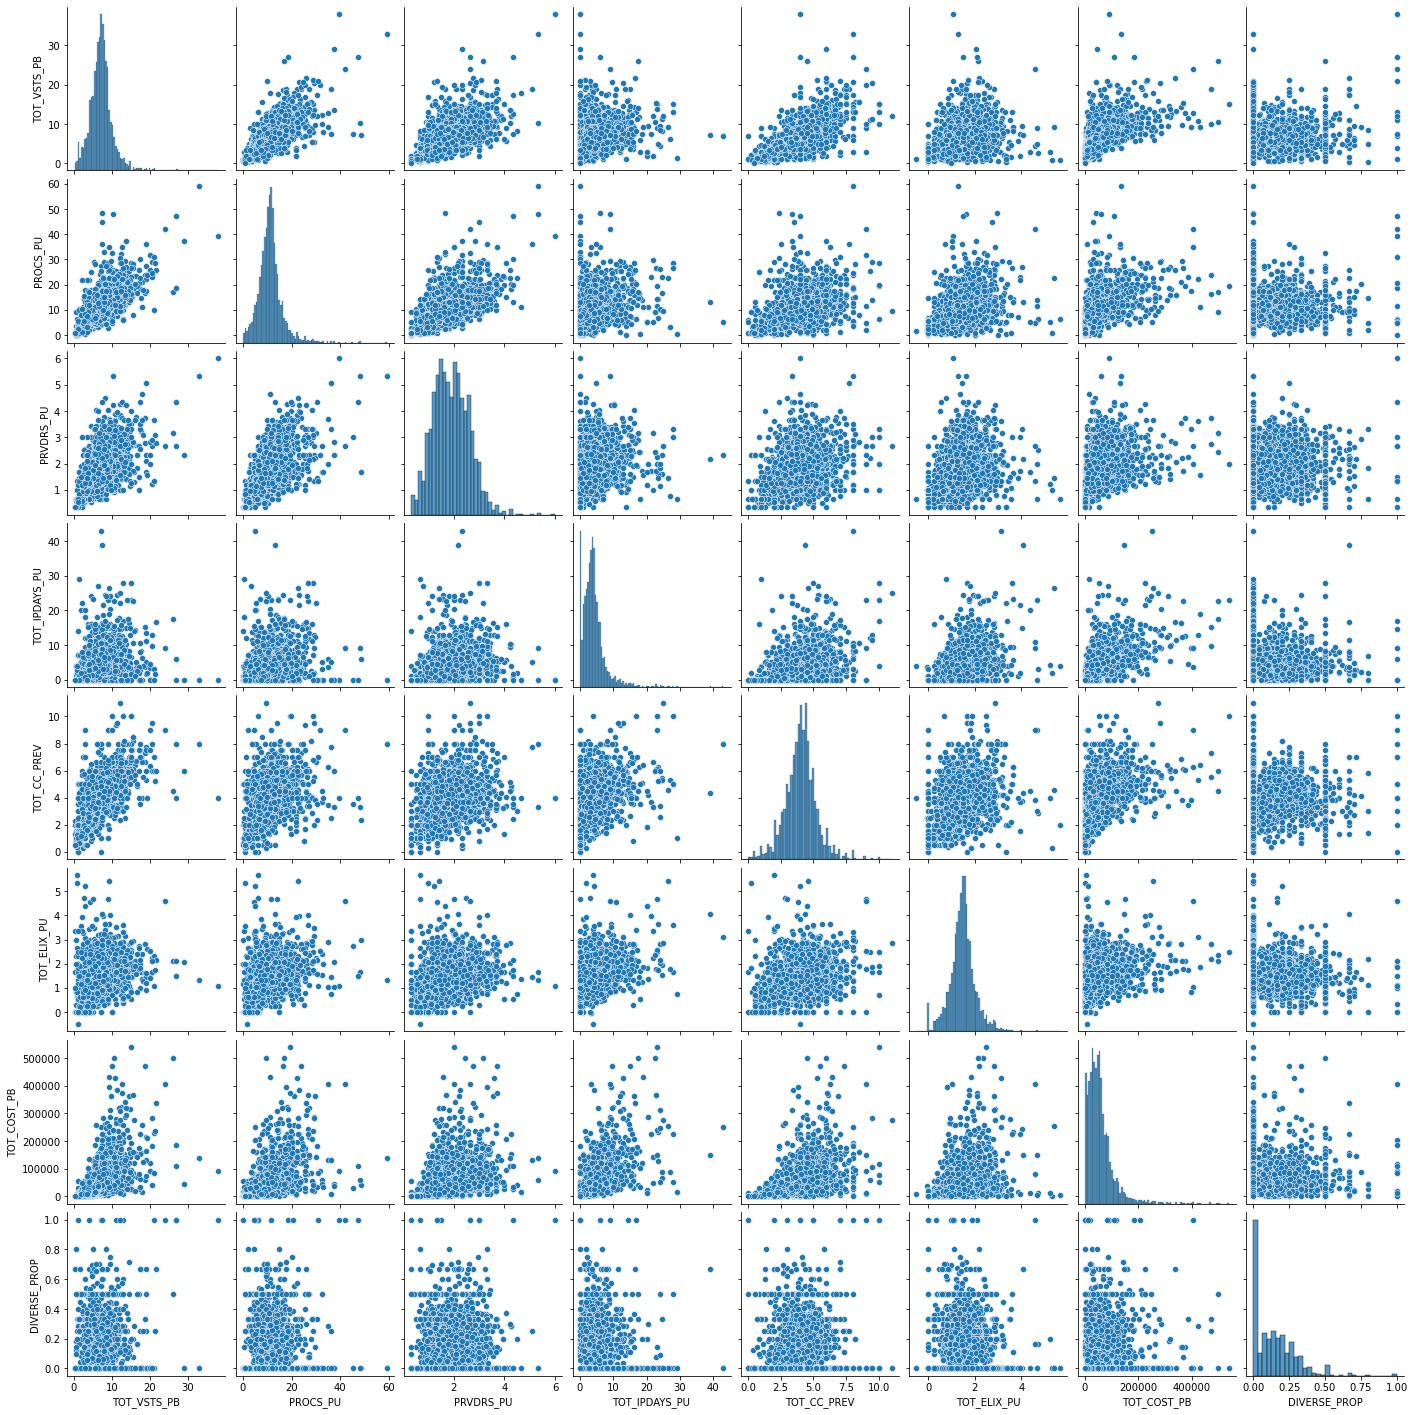

In [18]:
subset1 = analysis_ds[["TOT_VSTS_PB", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_CC_PREV", 
                       "TOT_ELIX_PU", "TOT_COST_PB", "DIVERSE_PROP"]]

sb.pairplot(subset1)

## Standardize the Data

In [23]:
s = pre.StandardScaler()
analysis_ds = s.fit_transform(analysis_ds)

## Kaiser Criterion & Scree Plot

Examining Eigenvalues to determine the number of observable factors (Latent variables).

In [24]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(analysis_ds)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([4.10866679, 1.20108795, 1.06771963, 0.99839774, 0.95034396,
       0.60250379, 0.52320386, 0.29696698, 0.15337853, 0.09773077])

There are only 3 eigenvalues > 1, so these would generally be the ones to retain.

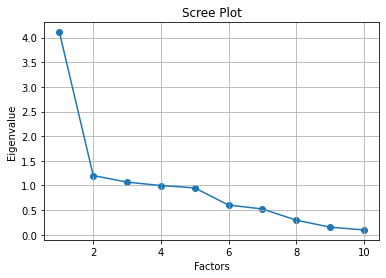

In [25]:
# Create scree plot 
plt.scatter(range(1,analysis_ds.shape[1]+1),ev)
plt.plot(range(1,analysis_ds.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [26]:
fa = FactorAnalyzer(rotation="varimax", n_factors=3)
fa.fit(analysis_ds)
fa.loadings_

array([[ 0.12140598,  0.00237094, -0.00262915],
       [ 0.71985809,  0.5270212 ,  0.1592064 ],
       [ 0.7831612 ,  0.20298909,  0.58460016],
       [ 0.80967049,  0.18119673,  0.25869441],
       [ 0.55824021,  0.14102727,  0.20932198],
       [ 0.06391747,  0.17937049,  0.73297798],
       [ 0.17344633,  0.95751398,  0.22544153],
       [ 0.13881056,  0.71034594,  0.21992756],
       [ 0.16491967,  0.13347919,  0.50966999],
       [ 0.01992552,  0.0128345 ,  0.02113144]])

## Loadings Analysis

**Factor 1** has high factor loadings for TOT_VSTS_PB, CODES_PU, PROCS_PU, PRVDRS_PU, and TOT_COST_PB. It has moderate loading for TOT_ELIX_PU.  It has the highest association with DIVERSE_PROP.  

**Factor 2** has high factor loadings for TOT_VSTS_PB, TOT_CC_PREV, TOT_CC_INCD and moderate for TOT_COST_PB. It has the highest association with HF_PROP_RANK.

**Factor 3** has high factor loadings for CNTY_IP_PROP, CODES_PU, TOT_IPDAYS_PU, TOT_ELIX_PU and TOT_COST_PB.

In [24]:
fa.get_communalities()

array([0.81583212, 0.62343668, 0.97117535, 0.7716961 , 0.36786685,
       0.73365914, 0.99835425, 0.56533156, 0.27341743, 0.56113785,
       0.00111265, 0.01393527])

## Communality

The amount of these variables' variance explained by their loading on the factors.

Highest explained: TOT_VSTS_PB, CNTY_IP_PROP, CODES_PU, PROCS_PU, TOT_IPDAYS_PU, TOT_CC_PREV

Somewhat explained: PRVDRS_PU, TOT_CC_INCD and TOT_COST_PB

In [25]:
fa.get_factor_variance()

(array([2.76570359, 1.97409935, 1.95715231]),
 array([0.2304753 , 0.16450828, 0.16309603]),
 array([0.2304753 , 0.39498358, 0.5580796 ]))

## Factor Variance

First array: Sum of squared loadings (total factor variance)
Second array: Proportional variance of that factor vs. other factors
Third array: Cumulative variance of all factors (from left to right)

The **First Factor** is by far the most significant, but the other two are also quite important.

The three factors together account for approximately **56%** of the total variance in these variables!

In [26]:
fa.get_uniquenesses()

array([0.18416788, 0.37656332, 0.02882465, 0.2283039 , 0.63213315,
       0.26634086, 0.00164575, 0.43466844, 0.72658257, 0.43886215,
       0.99888735, 0.98606473])

## Uniquenesses

These variance associated with only a specific varible.

Demographic variables tend to have very high uniqueness of variance.

In this case, the variables with the most uniqueness of variation were PRVDRS_PU, TOT_ELIX_PU, HF_PROP_RANK and DIVERSE_PROP.

This suggests these variables "are what they are" and that while they may be influential, they are not easily influenced.

## Can We Describe the Latent Variables / Factors?

## I propose / hypothesize: 

**Factor 1 is our Overutilization Factor.**  It explains / groups counties by Total Visits, Number of Codes, Number of Procedures, Number of Providers and Total Costs.  It has a moderate association with comorbidity, but interestingly, not much association at all with the Number of Chronic Condtions.  It's highest (but still weak) association with being not white possibly shows that there is systemic racism at work in the performance of potentially unnecessary procedures.

**Factor 2 is our Illness Factor.**  It explains / groups counties by Total Visits, Number of Chronic Conditions, Number of New Chronic Conditions (Incidence). It has a moderate association with Total Costs per Beneficiary.  

**Factor 3 is our Hospitalization Factor.**  It explains / groups counties by Proportion of Inpatient Visits, Number of Codes, Total Number of Inpatient Days.  It edges out Factor 1 in terms of explaining Total Costs per Beneficiary, but not by much.  This factor also has the highest association with TOT_ELIX_PU - which could be because counties with higher Elixhauser Scores per User have patients at higher risk for prolonged hospital stays / complications. 


In [27]:
# Reducing the data set based on the three factors 

df_reduced = fa.fit_transform(analysis_ds)
df_reduced

array([[-0.25088395,  0.78587327, -0.12281176],
       [ 0.65910404, -0.43147894,  0.2167964 ],
       [-0.23042533, -0.46938497,  0.22317846],
       ...,
       [-0.39821053, -1.64101657, -0.85808598],
       [ 0.27873268, -1.98806245, -0.67452623],
       [-1.46442182, -2.47030469, -1.05649271]])

In [28]:
FACTORS = pd.DataFrame(df_reduced, columns =["FACTORS_1", "FACTORS_2", "FACTORS_3"])


In [29]:
medicare_counties.shape

(2947, 68)

In [30]:
merged = medicare_counties.merge(FACTORS, left_index=True, right_index=True)

In [31]:
merged

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,HF_RANK,HF_PROP_RANK,HF_QUARTILE,HF_HIGH,HIGH_SEV,HIGH_PROCS,DIVERSE_PROP,FACTORS_1,FACTORS_2,FACTORS_3
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,10.0,0.851,1.0,1.0,0.0,1.0,0.312500,-0.250884,0.785873,-0.122812
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,3.0,0.955,1.0,1.0,1.0,1.0,0.368421,0.659104,-0.431479,0.216796
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,54.0,0.194,4.0,0.0,1.0,0.0,0.500000,-0.230425,-0.469385,0.223178
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,19.0,0.716,2.0,1.0,1.0,1.0,0.294118,0.538031,0.253332,-0.200188
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,9.0,0.866,1.0,1.0,0.0,0.0,0.409091,-0.354058,-1.479527,0.082009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,55.0,101.0,103,79,72.8,0.388350,11.0,10.0,22.0,717,...,64.0,0.111,4.0,0.0,0.0,0.0,0.087379,-0.237990,-1.348627,-0.568741
2905,55.0,103.0,9,4,80.0,0.666667,1.0,0.0,1.0,32,...,26.0,0.639,2.0,1.0,0.0,0.0,0.000000,-0.048580,-1.145311,-0.246286
2906,55.0,105.0,57,44,72.4,0.385965,2.0,3.0,6.0,417,...,62.0,0.139,4.0,0.0,0.0,0.0,0.070175,-0.398211,-1.641017,-0.858086
2907,55.0,107.0,14,8,68.2,0.571429,2.0,2.0,3.0,59,...,45.0,0.375,3.0,0.0,1.0,0.0,0.000000,0.278733,-1.988062,-0.674526


## Clustering based on Factors

Let's attempt KMeans clustering based on the Factors we have discovered.


In [33]:
from sklearn.cluster import KMeans

k = 5

clustered_df = pd.DataFrame()
kmeans = KMeans(n_clusters=k)
KM_FACTORS = kmeans.fit_predict(FACTORS)
clustered_df["KM_FACTORS"] = KM_FACTORS
clustered_df

,KM_FACTORS
0,1
1,3
2,3
3,3
4,2
...,...
2904,2
2905,2
2906,2
2907,2


In [34]:
merged = merged.iloc[:,0:71]
merged = merged.merge(clustered_df,  left_index=True, right_index=True)
merged.head()

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,HF_PROP_RANK,HF_QUARTILE,HF_HIGH,HIGH_SEV,HIGH_PROCS,DIVERSE_PROP,FACTORS_1,FACTORS_2,FACTORS_3,KM_FACTORS
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,0.851,1.0,1.0,0.0,1.0,0.312500,-0.250884,0.785873,-0.122812,1
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,0.955,1.0,1.0,1.0,1.0,0.368421,0.659104,-0.431479,0.216796,3
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,0.194,4.0,0.0,1.0,0.0,0.500000,-0.230425,-0.469385,0.223178,3
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,0.716,2.0,1.0,1.0,1.0,0.294118,0.538031,0.253332,-0.200188,3
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,0.866,1.0,1.0,0.0,0.0,0.409091,-0.354058,-1.479527,0.082009,2


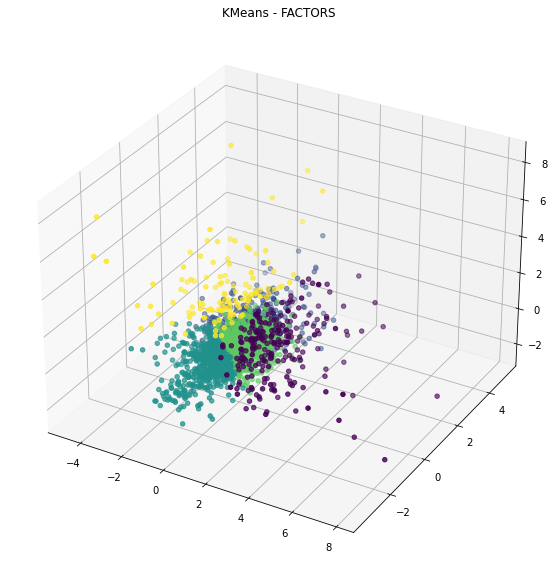

In [35]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
z = merged["FACTORS_3"]
x = merged["FACTORS_1"]
y = merged["FACTORS_2"]
c = merged["KM_FACTORS"]
ax.scatter(x, y, z, c=c)
ax.set_title('KMeans - FACTORS')
plt.show()

In [36]:
merged.to_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUSTERED.csv")